#Бибилиотеки

In [ ]:
#Установим библиотеку для отображения изменения accuracy и loss
!pip install livelossplot

In [2]:
#Загрузим необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
from livelossplot.tf_keras import PlotLossesCallback

#Подключимся к диску с данными

In [3]:
# Если работаем через google disk
# Подключимся к диску с данными
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
#Директория с датасетом
dir_path ='/content/gdrive/MyDrive/Final_work_3_DS/data_recommender_system'



---



##Нейронная сеть

Подготовка датасета

In [ ]:
#Загрузим необходимые датасеты
df_transactions = pd.read_csv(dir_path + '/transactions.csv')
df_products = pd.read_csv(dir_path + '/products.csv')

df_counter = pd.read_csv(dir_path + '/counter_df')

In [ ]:
#Описание user
#[id_user, Кол-во купленных товаров, Перезаказ товаров]

emb_user_df = pd.DataFrame()
emb_user_df['user_id'] = df_transactions.user_id.unique()
emb_user_df.index = df_transactions.user_id.unique()
emb_user_df['prod_count'] = df_transactions.groupby('user_id').count()['reordered']
emb_user_df['reordered_pr'] = round((df_transactions.groupby('user_id')\
                                     .sum()['reordered'] * 100) / df_transactions.groupby('user_id').count()['reordered'], 2)

In [ ]:
#Описание item
#[id_product, Сколько всего купили этот товар, 
# Процент перезаказа этого товара, Количество купленного товара конкретным user]

emb_item_df = pd.DataFrame()
emb_item_df['product_id'] = df_transactions.product_id.unique()
emb_item_df.index = df_transactions.product_id.unique()
emb_item_df['prod_count_total'] = df_transactions.groupby('product_id').count()['reordered']
emb_item_df['reordered_pr_total'] = round((df_transactions.groupby('product_id')\
                                     .sum()['reordered'] * 100) / df_transactions.groupby('product_id').count()['reordered'], 2)

In [ ]:
#Объединим все таблицы в одну train_df
train_df = df_transactions.loc[:, ['user_id', 'product_id', 'reordered']].copy()
train_df = train_df.merge(emb_user_df, on='user_id')
train_df = train_df.merge(emb_item_df, on='product_id')
train_df = train_df.merge(df_counter, on=['user_id', 'product_id'])

Сохрание и загрузка итогового датасета

In [ ]:
# #Сохраним df
# train_df.to_csv(dir_path + '/train_df_NN')

# #Загрузить df
# train_df = pd.read_csv(dir_path + '/train_df_NN')

Сформируем архитектуру нс

In [ ]:
#Кол-во users и items
num_users = len(pd.unique(train_df.user_id)) +1
num_items = len(pd.unique(train_df.product_id)) +1

#Создаем два входных слоя
user_input = tf.keras.layers.Input(shape=(3,), dtype='int32', name = 'user_input')
item_input = tf.keras.layers.Input(shape=(4,), dtype='int32', name = 'item_input')

In [ ]:
#Вытягиваем и склеиваем в один слой
user_latent = tf.keras.layers.Flatten()(user_input)
item_latent = tf.keras.layers.Flatten()(item_input)

vector = tf.keras.layers.Concatenate()([user_latent, item_latent])

#Слои модели после склеивания эмбеддингов
layer1 = tf.keras.layers.Dense(64, input_shape = (num_users+num_items, ), activation='relu')(vector)
layer2 = tf.keras.layers.Dense(32, activation='relu')(layer1)
layer3 = tf.keras.layers.Dense(16, activation='relu')(layer2)
output_layer = tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer='l2')(layer3)

In [ ]:
#Модель
model = tf.keras.Model(inputs=[user_input, item_input], outputs=[output_layer])

In [ ]:
# tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
optimizer = tf.keras.optimizers.Adam(lr = 0.001)
loss = tf.keras.losses.binary_crossentropy
model.compile(optimizer=optimizer, loss=loss, metrics=['MSE'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Обучим модель

In [ ]:
y = train_df['reordered']

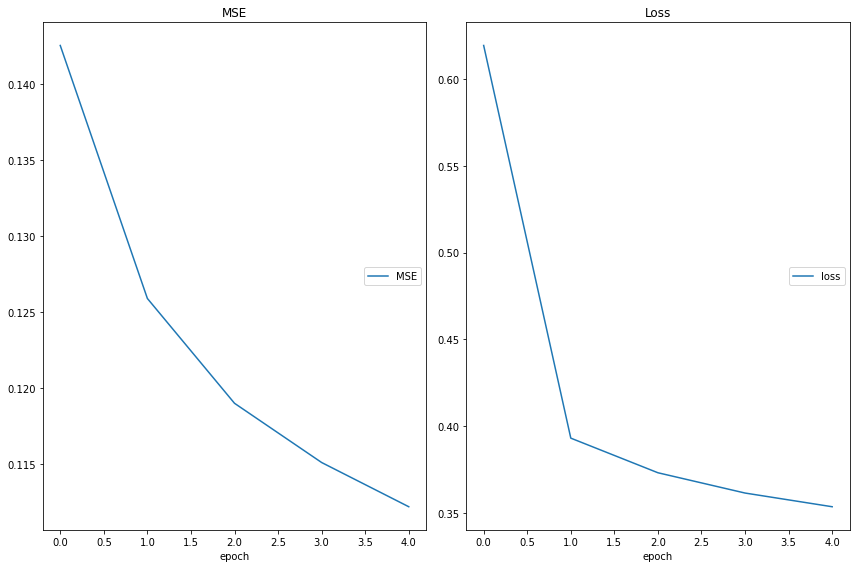

MSE
	MSE              	 (min:    0.112, max:    0.143, cur:    0.112)
Loss
	loss             	 (min:    0.354, max:    0.619, cur:    0.354)
825253/825253 [==============================] - 1574s 2ms/step - loss: 0.3535 - MSE: 0.1122


In [ ]:
model.fit([train_df.loc[:, ['user_id', 'prod_count', 'reordered_pr']], 
           train_df.loc[:, ['product_id', 'prod_count_total', 'reordered_pr_total', 'count']]], 
          y, 
          epochs=5,
          callbacks=[PlotLossesCallback()])

In [ ]:
#Сохранить веса модели
model.save_weights(dir_path + '/checkpoint_best_5epochs', save_format='tf')

Сформируем predictions

In [ ]:
#Загрузим веса
model.load_weights(dir_path + '/checkpoint_best_5epochs')

In [ ]:
#Сформируем датасет для prediction общий
train_df_predict = train_df[train_df.reordered == 0]
prediction_df = train_df_predict.copy()
prediction_df['Prediction'] = None


for i in tqdm(train_df_predict.user_id.unique()):
  user_emb = train_df_predict[train_df_predict.user_id == i][['user_id', 
                                                             'prod_count',
                                                             'reordered_pr']]

  item_emb = train_df_predict[train_df_predict.user_id == i][['product_id',
                                                              'prod_count_total',
                                                              'reordered_pr_total',
                                                              'count']]
  prediction =  model.predict([user_emb, item_emb], batch_size=20, verbose=False).reshape(-1)
  prediction_df.loc[item_emb.index, 'Prediction'] = prediction

In [22]:
#Сохраним df total
prediction_df.to_csv(dir_path + '/prediction_df_total.csv')

Результаты работы модели

In [24]:
#Загрузить датасет с predictions
prediction_df_total = pd.read_csv(dir_path + '/prediction_df_total.csv')

In [26]:
#Отсортируем
prediction_df_total = prediction_df_total.sort_values('user_id', ascending=True)[['user_id','product_id', 'Prediction']]

In [81]:
#Сформируем файл посмотрим на результат
submission_df = pd.DataFrame()
submission_df['user_id'] = prediction_df_total.user_id.unique()
submission_df.index = submission_df.user_id.unique()
submission_df['product_id'] = None

In [82]:
#Все уникальные продукты
all_products = prediction_df_total.product_id.unique()

In [ ]:
for i in tqdm(prediction_df_total.user_id.unique()):

  top_pr = prediction_df_total[prediction_df_total.user_id == i][['product_id',
                                                                  'Prediction']].sort_values('Prediction', ascending=False).head(10)
  #Берем десять наиболее популярных товаров (по prediction)
  if len(top_pr) == 10:
    products = top_pr['product_id'].tolist()
    pred = [str(x) for x in products]
    submission_df.at[i, 'product_id'] = " ".join(pred)

  #Если товаров менее 10, возьмем рандомные товары
  else:
    products = top_pr['product_id'].tolist()

    delta = 10 - len(top_pr)
    p = np.random.choice(all_products, delta, replace=False).tolist()
    products += p

    pred = [str(x) for x in products]
    submission_df.at[i, 'product_id'] = " ".join(pred)

In [87]:
#Сохраним результаты
submission_df.to_csv(dir_path + '/submission.csv', sep=',', index=False)

Результаты работы модели с кодировкой признаков (MAP@10):

**Score:** 0.27304